# 1. Load the Saved Correlation Matrices

In [2]:
import numpy as np
import os

# Directory where correlation matrices are saved
corr_dir = os.path.expanduser("~/correlation_matrices")

# Correlation types
correlation_types = ["correlation", "partial correlation", "tangent"]

# Dictionary to store loaded matrices
correlation_matrices = {}

# Load each correlation matrix file
for kind in correlation_types:
    file_path = os.path.join(corr_dir, f"{kind}_correlation_matrices.npz")
    data = np.load(file_path)
    correlation_matrices[kind] = data["matrices"]
    print(f"{kind}: {correlation_matrices[kind].shape}")


correlation: (155, 39, 39)
partial correlation: (155, 39, 39)
tangent: (155, 39, 39)


- 155 subjets 
- each with a 39x39 correlation matrix (between 39 regions)

# 2. Extract the Upper Triangle (excluding diagonal)

Goal:

- Each subject’s 39×39 correlation matrix is symmetric, meaning the upper and lower halves mirror each other. So we only need the upper triangle (excluding the diagonal) to capture all unique pairwise region connections — no redundancy, no self-loops.



In [3]:
# Get indices for the upper triangle without diagonal

#each correlation matrix is 39x39 (one per subject)
#shape[1] gets the second dimension, which is 39. (39 brain regions per subject)
n_nodes = correlation_matrices["correlation"].shape[1]

'''
For 39 nodes, that gives us 741 values (since matrix is symmetrical)
(since 39C2 = 741 unique region-to-region connections).
'''
upper_idx = np.triu_indices(n_nodes, k=1)  # gets indices for upper triangle and k=1 excludes diagonal

# Function to extract upper triangles from a 3D matrix set
'''
Takes a set of correlation matrices 
For each subject, extracts just the upper triangle values
Returns an array of shape (155, 741) — one flattened feature vector per subject.
'''
def extract_upper_triangles(matrix_set):
    b = np.array([matrix[upper_idx] for matrix in matrix_set]) #np. array turns it into a 2d array 
    print(b.shape)
    return b 
# Dictionary to store upper triangle features
'''
Loops over each correlation type
Applies the function to extract the features
Stores the results in upper_triangle_features dict
'''
upper_triangle_features = {}

for kind in correlation_types:
    upper_triangle_features[kind] = extract_upper_triangles(correlation_matrices[kind])
    print(f"{kind} features shape: {upper_triangle_features[kind].shape}")


(155, 741)
correlation features shape: (155, 741)
(155, 741)
partial correlation features shape: (155, 741)
(155, 741)
tangent features shape: (155, 741)


### 🧠 Why Upper Triangle?
We started with 155 subjects, each with a 39x39 matrix showing how brain regions are connected but this includes a lot of repeated values because the matrices are symmetric.

Also, the diagonal is always 1, which isn't helpful for learning (it's just a region connected to itself)

Now, for 39 brain regions, there are 741 unique pairs. So now each subject is described by 741 numbers (instead of a full 39×39 matrix).

- Shape (155, 741): 
   - 155 people
   - Each person is represented by 741 features (how strongly their brain regions connect)

# 3. Load Labels and Split the Data

Goal:
To load the class labels (child/adult), check the distribution, and split the data into training and testing sets for each type of correlation matrix.


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Load class labels
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Confirm shape and class balance (shoes how many of each class we have)
print("Labels shape:", labels.shape) #155 labels 
print("Class distribution:", np.unique(labels, return_counts=True)) #122 children, 33 adults

# empty dictionary to store Train-test split for each correlation type
split_data = {}

'''
For each correlation type:
- x =  741-feature vector per subject from the upper triangle
- y = class labels
- train_test_split(...) splits into:
  - 80% training, 20% testing
  - stratify=y ensures the same class ratio is maintained in both sets
'''
for kind in correlation_types:  # ["correlation", "partial correlation", "tangent"]
    X = upper_triangle_features[kind]
    y = labels
    #split data 80/40
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    #save split into a dictionary 
    split_data[kind] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test
    }

    print(f"{kind} ➤ Train: {X_train.shape}, Test: {X_test.shape}")


Labels shape: (155,)
Class distribution: (array([0, 1]), array([122,  33]))
correlation ➤ Train: (124, 741), Test: (31, 741)
partial correlation ➤ Train: (124, 741), Test: (31, 741)
tangent ➤ Train: (124, 741), Test: (31, 741)


- 155 subjects 
- 122 children (0) and 33 adults (1)
- 124 train samples
- 31 test samples
- 741 features per sample (from upper triangle)

# 4. Hyperparameter Tuning with GridSearchCV for Each Correlation Type


GridSearchCV is a scikit-learn tool for hyperparameter tuning that systematically explores a predefined grid of hyperparameters, evaluating the model's performance using cross-validation to find the best combination. 

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Grid search parameters 

'''
3 layer configs 
2 activation functions 
2 a values 
2 learning rates
= 3 × 2 × 2 × 2 = 24 combinations (layer sizes, activation func, regularization, learning rate)
'''
param_grid = {
    #(64, 31) - 2 hidden layers: first with 64 neurons, second with 32
    #(128, 64) - 2 hidden layers: 128 and 64 neurons
    #(128, 64, 32) - 3 hidden layers: 128,64 and 32 neurons
    "hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001], #regularization strength: helps prevent overfitting by discouraging overly large weights 
    "learning_rate_init": [0.001, 0.01]
}

best_models = {} #stores the best-performing MLP for each correlation type
scalers = {} #stores the fitted scalers for later standardization

for kind in correlation_types:
    print(f"\n🔍 Running GridSearchCV for {kind.upper()} correlation...")

    # ✅ Use only the training data
    X_train = split_data[kind]["X_train"]
    y_train = split_data[kind]["y_train"]

    # ✅ Standardize only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    scalers[kind] = scaler

    # ✅ GridSearch only on training data
    mlp = MLPClassifier(max_iter=1000, early_stopping=True, random_state=42)
    grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    print(f"✅ Best parameters for {kind}: {grid_search.best_params_}")
    print(f"📈 Best CV Accuracy for {kind}: {grid_search.best_score_:.4f}")

    # Save the best trained model
    best_models[kind] = grid_search.best_estimator_




🔍 Running GridSearchCV for CORRELATION correlation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best parameters for correlation: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}
📈 Best CV Accuracy for correlation: 0.9110

🔍 Running GridSearchCV for PARTIAL CORRELATION correlation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best parameters for partial correlation: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
📈 Best CV Accuracy for partial correlation: 0.9033

🔍 Running GridSearchCV for TANGENT correlation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best parameters for tangent: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
📈 Best CV Accuracy for tangent: 0.9597


# 5. Evaluate Final MLP Models on Test Set with Confusion Matrices



📊 Final MLP Classification Report (Correlation)
              precision    recall  f1-score   support

       Child       0.89      1.00      0.94        24
       Adult       1.00      0.57      0.73         7

    accuracy                           0.90        31
   macro avg       0.94      0.79      0.83        31
weighted avg       0.91      0.90      0.89        31



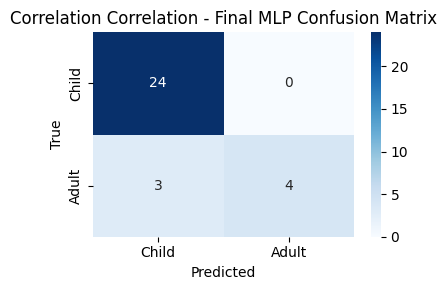


📊 Final MLP Classification Report (Partial Correlation)
              precision    recall  f1-score   support

       Child       0.85      0.96      0.90        24
       Adult       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



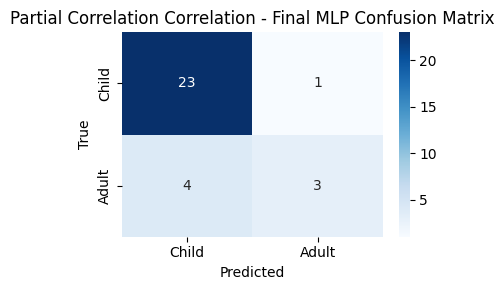


📊 Final MLP Classification Report (Tangent)
              precision    recall  f1-score   support

       Child       0.85      0.96      0.90        24
       Adult       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



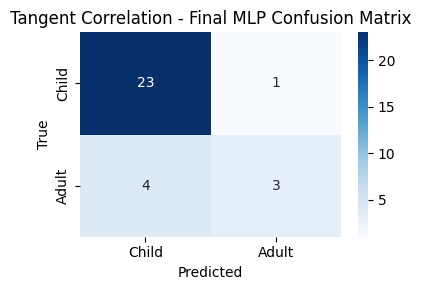

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for kind in correlation_types: #loop through correlation types
    print(f"\n📊 Final MLP Classification Report ({kind.title()})")
    #pulls the saved test data for the kind of correlation matrix in question
    X_test = split_data[kind]["X_test"]
    y_test = split_data[kind]["y_test"]

    # Use the StandardScaler and trained MLPClassifier for each correlation(done during training)
    scaler = scalers[kind]
    model = best_models[kind]
    
    #apply the same scaling as the training set
    X_test_scaled = scaler.transform(X_test)
    #predict labels for the test set
    y_pred = model.predict(X_test_scaled)
    
    print(classification_report(y_test, y_pred, target_names=["Child", "Adult"]))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred) #2x2 matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Child", "Adult"], yticklabels=["Child", "Adult"])
    plt.title(f"{kind.title()} Correlation - Final MLP Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


### 🧠 Final Evaluation Summary — Multi-Layer Perceptron (MLP)

#### 🔧 Best Hyperparameters (from GridSearchCV)

| Correlation Type       | Hidden Layers | Activation | Learning Rate | Alpha   | CV Accuracy |
|------------------------|----------------|------------|----------------|---------|-------------|
| Correlation            | (128, 64)      | relu       | 0.001          | 0.0001  | 0.9110      |
| Partial Correlation    | (128, 64)      | relu       | 0.01           | 0.0001  | 0.9033      |
| Tangent                | (128, 64)      | relu       | 0.01           | 0.0001  | 0.9597      |

---

#### 📊 Final Test Results

**Correlation**
- Accuracy: **0.90**
- Macro F1-score: **0.83**
- Adult Recall: **0.57**


**Partial Correlation**
- Accuracy: **0.84**
- Macro F1-score: **0.72**
- Adult Recall: **0.43**


**Tangent**
- Accuracy: **0.84**
- Macro F1-score: **0.72**
- Adult Recall: **0.43**



# 6. 5 Fold CV


🔁 Stratified K-Fold MLP Evaluation for CORRELATION correlation

📂 Fold 1 Accuracy: 0.8387
              precision    recall  f1-score   support

       Child       0.85      0.96      0.90        24
       Adult       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



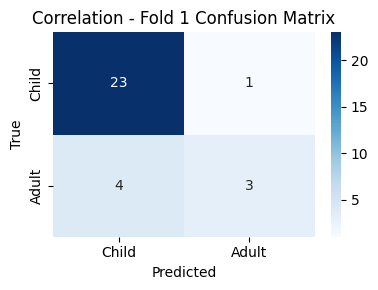


📂 Fold 2 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.89      1.00      0.94        24
       Adult       1.00      0.57      0.73         7

    accuracy                           0.90        31
   macro avg       0.94      0.79      0.83        31
weighted avg       0.91      0.90      0.89        31



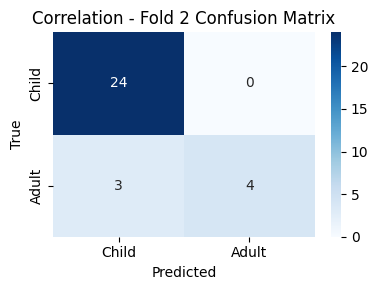


📂 Fold 3 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.89      1.00      0.94        24
       Adult       1.00      0.57      0.73         7

    accuracy                           0.90        31
   macro avg       0.94      0.79      0.83        31
weighted avg       0.91      0.90      0.89        31



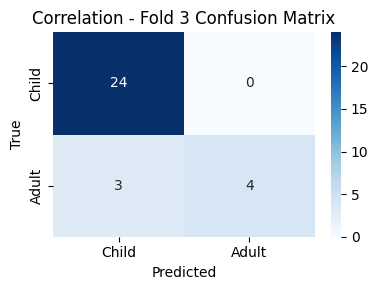


📂 Fold 4 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.89      1.00      0.94        25
       Adult       1.00      0.50      0.67         6

    accuracy                           0.90        31
   macro avg       0.95      0.75      0.81        31
weighted avg       0.91      0.90      0.89        31



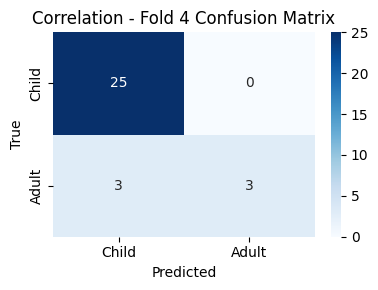


📂 Fold 5 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.96      0.92      0.94        25
       Adult       0.71      0.83      0.77         6

    accuracy                           0.90        31
   macro avg       0.84      0.88      0.85        31
weighted avg       0.91      0.90      0.91        31



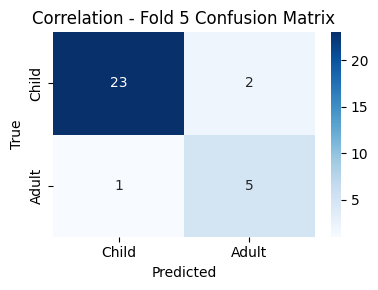


✅ Mean Accuracy for correlation: 0.8903 ± 0.0258

🔁 Stratified K-Fold MLP Evaluation for PARTIAL CORRELATION correlation

📂 Fold 1 Accuracy: 0.8387
              precision    recall  f1-score   support

       Child       0.83      1.00      0.91        24
       Adult       1.00      0.29      0.44         7

    accuracy                           0.84        31
   macro avg       0.91      0.64      0.68        31
weighted avg       0.87      0.84      0.80        31



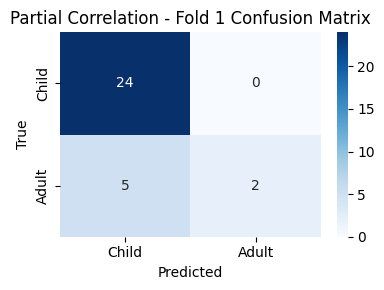


📂 Fold 2 Accuracy: 0.8387
              precision    recall  f1-score   support

       Child       0.85      0.96      0.90        24
       Adult       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



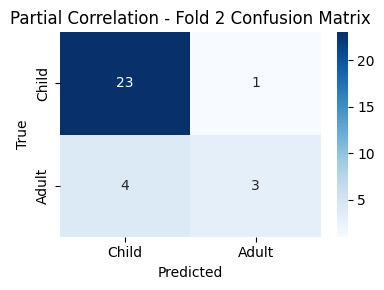


📂 Fold 3 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.89      1.00      0.94        24
       Adult       1.00      0.57      0.73         7

    accuracy                           0.90        31
   macro avg       0.94      0.79      0.83        31
weighted avg       0.91      0.90      0.89        31



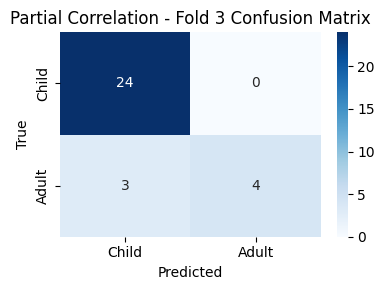


📂 Fold 4 Accuracy: 0.8387
              precision    recall  f1-score   support

       Child       0.83      1.00      0.91        25
       Adult       1.00      0.17      0.29         6

    accuracy                           0.84        31
   macro avg       0.92      0.58      0.60        31
weighted avg       0.87      0.84      0.79        31



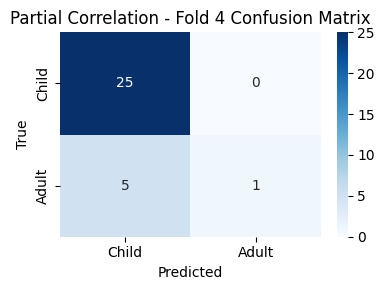


📂 Fold 5 Accuracy: 0.8710
              precision    recall  f1-score   support

       Child       0.86      1.00      0.93        25
       Adult       1.00      0.33      0.50         6

    accuracy                           0.87        31
   macro avg       0.93      0.67      0.71        31
weighted avg       0.89      0.87      0.84        31



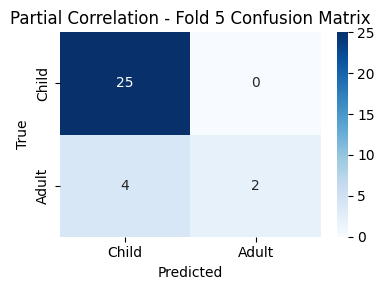


✅ Mean Accuracy for partial correlation: 0.8581 ± 0.0258

🔁 Stratified K-Fold MLP Evaluation for TANGENT correlation

📂 Fold 1 Accuracy: 0.8710
              precision    recall  f1-score   support

       Child       0.86      1.00      0.92        24
       Adult       1.00      0.43      0.60         7

    accuracy                           0.87        31
   macro avg       0.93      0.71      0.76        31
weighted avg       0.89      0.87      0.85        31



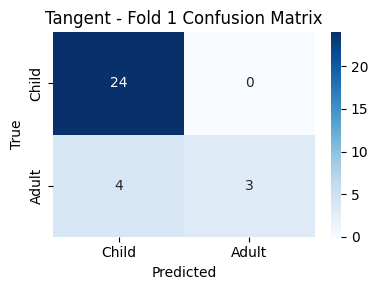


📂 Fold 2 Accuracy: 0.8387
              precision    recall  f1-score   support

       Child       0.85      0.96      0.90        24
       Adult       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



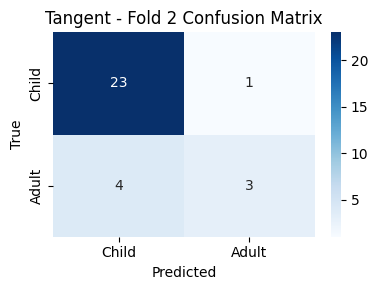


📂 Fold 3 Accuracy: 0.8387
              precision    recall  f1-score   support

       Child       0.85      0.96      0.90        24
       Adult       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



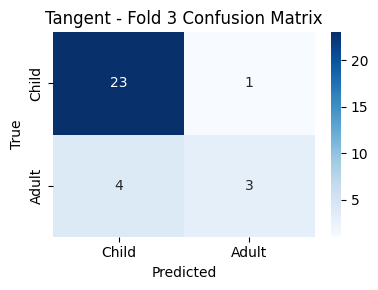


📂 Fold 4 Accuracy: 0.9355
              precision    recall  f1-score   support

       Child       0.93      1.00      0.96        25
       Adult       1.00      0.67      0.80         6

    accuracy                           0.94        31
   macro avg       0.96      0.83      0.88        31
weighted avg       0.94      0.94      0.93        31



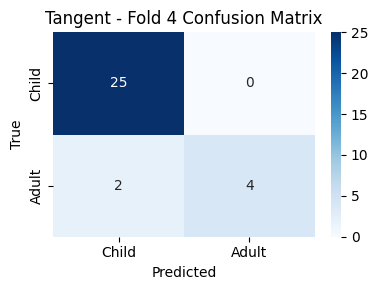


📂 Fold 5 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.92      0.96      0.94        25
       Adult       0.80      0.67      0.73         6

    accuracy                           0.90        31
   macro avg       0.86      0.81      0.83        31
weighted avg       0.90      0.90      0.90        31



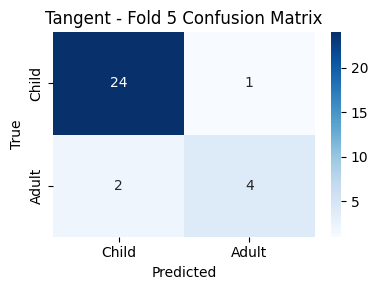


✅ Mean Accuracy for tangent: 0.8774 ± 0.0376


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Reload labels in case they were overwritten
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Run Stratified K-Fold for each correlation type
for kind in correlation_types:
    print(f"\n🔁 Stratified K-Fold MLP Evaluation for {kind.upper()} correlation")

    X = upper_triangle_features[kind] #feature matrix (155 samples, 741 features)
    y = labels.copy() #class labels

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #initializr stratified kfold cross-validator
    accuracies = [] #stores test accuracy for each fold 
    fold = 1 #counter to track which fold is running

    for train_index, test_index in skf.split(X, y): #splits indices for training and testing
        X_train, X_test = X[train_index], X[test_index] #selects actual data for train/test
        y_train, y_test = y[train_index], y[test_index] 

        # Scale
        scaler = StandardScaler() #create new standardscaler to normalize features 
        X_train_scaled = scaler.fit_transform(X_train) #fit scaler on training set and scale(z score normalization)
        X_test_scaled = scaler.transform(X_test) #applies same scaling parameters from training to scale the test set

        # Train MLP
        '''
        Two hidden layers: 128 and 64 neurons.
        ReLU activation.
        L2 regularization strength: alpha=0.0001.
        Learning rate: 0.001.
        Stops early if no improvement during training.
        random_state=42 for reproducibility.
        '''
        mlp = MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            alpha=0.0001,
            learning_rate_init=0.001,
            max_iter=1000,
            early_stopping=True,
            random_state=42
        )
        mlp.fit(X_train_scaled, y_train) #train mlp model on the scaled training data
        y_pred = mlp.predict(X_test_scaled) #use trained model to predict on the scaled test set 
        
        #calculate accuracy and store
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        print(f"\n📂 Fold {fold} Accuracy: {acc:.4f}")
        #precisioin, recall, f1 score
        print(classification_report(y_test, y_pred, target_names=["Child", "Adult"]))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred) #confusion matrix 
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=["Child", "Adult"],
                    yticklabels=["Child", "Adult"])
        plt.title(f"{kind.title()} - Fold {fold} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        fold += 1

    print(f"\n✅ Mean Accuracy for {kind}: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


- ✅ Mean Accuracy for correlation: 0.8903 ± 0.0258
- ✅ Mean Accuracy for partial correlation: 0.8581 ± 0.0258
- ✅ Mean Accuracy for tangent: 0.8774 ± 0.0376

| Correlation Type     | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|----------------------|--------|--------|--------|--------|--------|
| **Correlation**      | 0.8387 | 0.9032 | 0.9032 | 0.9032 | 0.9032 |
| **Partial Correlation** | 0.8387 | 0.8387 | 0.9032 | 0.8387 | 0.8710 |
| **Tangent**          | 0.8710 | 0.8387 | 0.8387 | 0.9355 | 0.9032 |


### 📊 Stratified K-Fold MLP Accuracy Summary

| Correlation Type       | Mean Accuracy | Std Dev  | Mean Adult Recall |
|------------------------|---------------|----------|--------------------|
| **Correlation**        | **89.03%**    | ±2.58%   | 58%                |
| **Partial Correlation**| 85.81%        | ±2.58%   | 35.8%              |
| **Tangent**            | 87.42%        | ±3.59%   | 52.6%              |

---

**Insights**:
- Correlation had the most consistent and strong performance.
- Tangent showed highest single-fold performance but more variability.
- Partial correlation struggled with Adult class recall in some folds.

⚠️ Adult class recall was consistently lower across folds due to class imbalance.


# 7. 5 Fold CV With Random Oversampling


🔁 Stratified K-Fold MLP Evaluation for CORRELATION correlation

📂 Fold 1 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.92      0.96      0.94        24
       Adult       0.83      0.71      0.77         7

    accuracy                           0.90        31
   macro avg       0.88      0.84      0.85        31
weighted avg       0.90      0.90      0.90        31



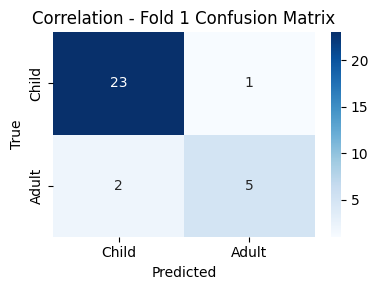


📂 Fold 2 Accuracy: 0.8710
              precision    recall  f1-score   support

       Child       0.88      0.96      0.92        24
       Adult       0.80      0.57      0.67         7

    accuracy                           0.87        31
   macro avg       0.84      0.76      0.79        31
weighted avg       0.87      0.87      0.86        31



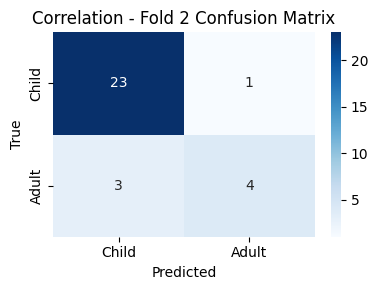


📂 Fold 3 Accuracy: 0.8065
              precision    recall  f1-score   support

       Child       0.82      0.96      0.88        24
       Adult       0.67      0.29      0.40         7

    accuracy                           0.81        31
   macro avg       0.74      0.62      0.64        31
weighted avg       0.79      0.81      0.78        31



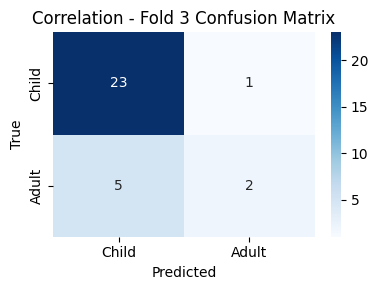


📂 Fold 4 Accuracy: 0.9677
              precision    recall  f1-score   support

       Child       0.96      1.00      0.98        25
       Adult       1.00      0.83      0.91         6

    accuracy                           0.97        31
   macro avg       0.98      0.92      0.94        31
weighted avg       0.97      0.97      0.97        31



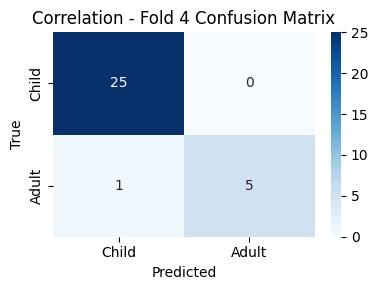


📂 Fold 5 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.96      0.92      0.94        25
       Adult       0.71      0.83      0.77         6

    accuracy                           0.90        31
   macro avg       0.84      0.88      0.85        31
weighted avg       0.91      0.90      0.91        31



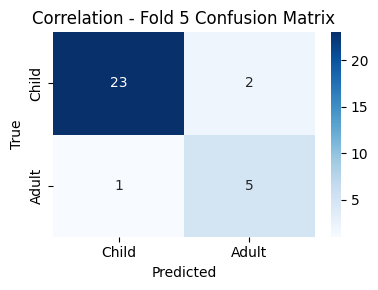


✅ Mean Accuracy for correlation: 0.8903 ± 0.0524

🔁 Stratified K-Fold MLP Evaluation for PARTIAL CORRELATION correlation

📂 Fold 1 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.89      1.00      0.94        24
       Adult       1.00      0.57      0.73         7

    accuracy                           0.90        31
   macro avg       0.94      0.79      0.83        31
weighted avg       0.91      0.90      0.89        31



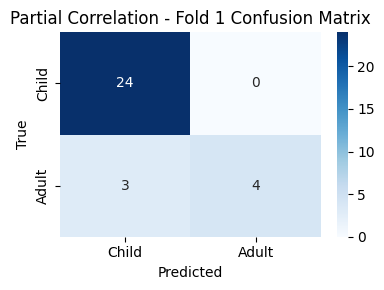


📂 Fold 2 Accuracy: 0.7742
              precision    recall  f1-score   support

       Child       0.87      0.83      0.85        24
       Adult       0.50      0.57      0.53         7

    accuracy                           0.77        31
   macro avg       0.68      0.70      0.69        31
weighted avg       0.79      0.77      0.78        31



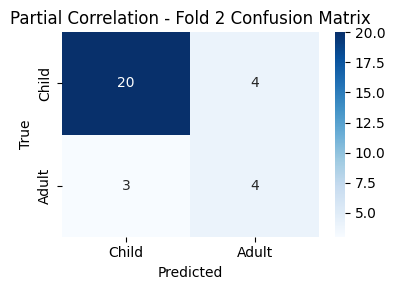


📂 Fold 3 Accuracy: 0.7742
              precision    recall  f1-score   support

       Child       0.79      0.96      0.87        24
       Adult       0.50      0.14      0.22         7

    accuracy                           0.77        31
   macro avg       0.65      0.55      0.55        31
weighted avg       0.73      0.77      0.72        31



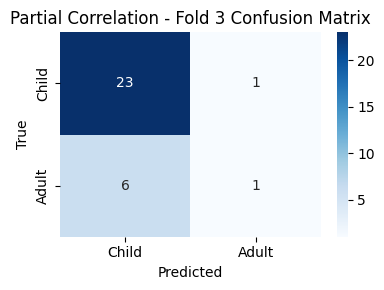


📂 Fold 4 Accuracy: 0.8065
              precision    recall  f1-score   support

       Child       0.88      0.88      0.88        25
       Adult       0.50      0.50      0.50         6

    accuracy                           0.81        31
   macro avg       0.69      0.69      0.69        31
weighted avg       0.81      0.81      0.81        31



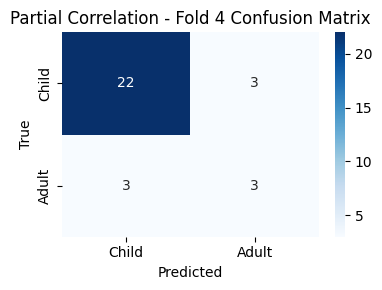


📂 Fold 5 Accuracy: 0.8710
              precision    recall  f1-score   support

       Child       0.89      0.96      0.92        25
       Adult       0.75      0.50      0.60         6

    accuracy                           0.87        31
   macro avg       0.82      0.73      0.76        31
weighted avg       0.86      0.87      0.86        31



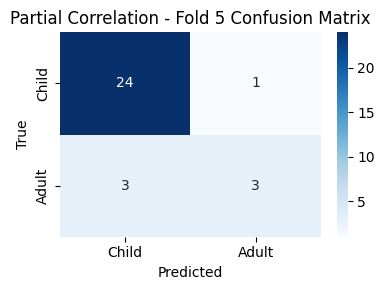


✅ Mean Accuracy for partial correlation: 0.8258 ± 0.0524

🔁 Stratified K-Fold MLP Evaluation for TANGENT correlation

📂 Fold 1 Accuracy: 0.9677
              precision    recall  f1-score   support

       Child       0.96      1.00      0.98        24
       Adult       1.00      0.86      0.92         7

    accuracy                           0.97        31
   macro avg       0.98      0.93      0.95        31
weighted avg       0.97      0.97      0.97        31



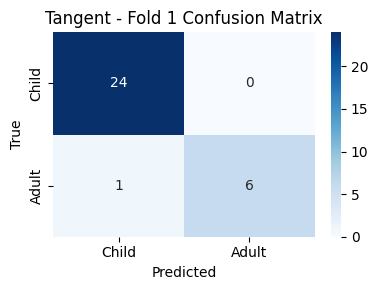


📂 Fold 2 Accuracy: 0.7742
              precision    recall  f1-score   support

       Child       0.84      0.88      0.86        24
       Adult       0.50      0.43      0.46         7

    accuracy                           0.77        31
   macro avg       0.67      0.65      0.66        31
weighted avg       0.76      0.77      0.77        31



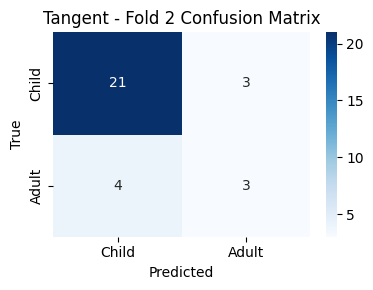


📂 Fold 3 Accuracy: 0.8710
              precision    recall  f1-score   support

       Child       0.88      0.96      0.92        24
       Adult       0.80      0.57      0.67         7

    accuracy                           0.87        31
   macro avg       0.84      0.76      0.79        31
weighted avg       0.87      0.87      0.86        31



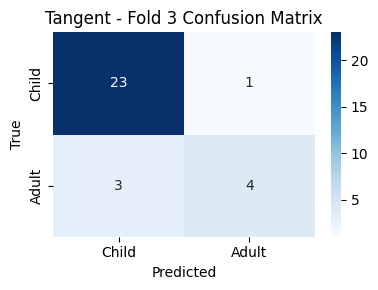


📂 Fold 4 Accuracy: 0.9032
              precision    recall  f1-score   support

       Child       0.92      0.96      0.94        25
       Adult       0.80      0.67      0.73         6

    accuracy                           0.90        31
   macro avg       0.86      0.81      0.83        31
weighted avg       0.90      0.90      0.90        31



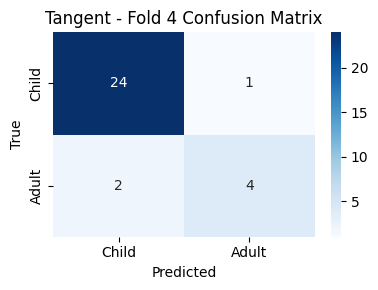


📂 Fold 5 Accuracy: 0.8710
              precision    recall  f1-score   support

       Child       0.92      0.92      0.92        25
       Adult       0.67      0.67      0.67         6

    accuracy                           0.87        31
   macro avg       0.79      0.79      0.79        31
weighted avg       0.87      0.87      0.87        31



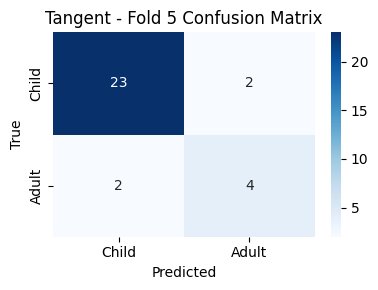


✅ Mean Accuracy for tangent: 0.8774 ± 0.0626


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Reload labels in case they were overwritten
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Run Stratified K-Fold for each correlation type
for kind in correlation_types:
    print(f"\n🔁 Stratified K-Fold MLP Evaluation for {kind.upper()} correlation")

    X = upper_triangle_features[kind]
    y = labels.copy()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    fold = 1

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # !!! Oversample the training data to handle class imbalance !!!
        ros = RandomOverSampler(random_state=42) #create an oversampler object
        '''
        ros.fit_resample(X_train, y_train): 
        makes the num of adult and child samples equal in the training set by:
        - keeping all original adult samples
        - randomly suplicating existing "adult" samples until they match the number of child samples
        finally returns new balances training features and labels 
        '''
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

        # Scale
        scaler = StandardScaler() #0 mean and unit variance
        X_train_scaled = scaler.fit_transform(X_train_resampled)
        X_test_scaled = scaler.transform(X_test)

        # Train MLP
        mlp = MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            alpha=0.0001,
            learning_rate_init=0.001,
            max_iter=1000,
            early_stopping=True,
            random_state=42
        )

        mlp.fit(X_train_scaled, y_train_resampled)
        y_pred = mlp.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        print(f"\n📂 Fold {fold} Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=["Child", "Adult"]))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=["Child", "Adult"],
                    yticklabels=["Child", "Adult"])
        plt.title(f"{kind.title()} - Fold {fold} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        fold += 1

    print(f"\n✅ Mean Accuracy for {kind}: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


#### MLP Accuracy Across 5 Folds (Using Random Oversampling)

| Correlation Type     | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Mean Accuracy | Std Dev |
|----------------------|--------|--------|--------|--------|--------|----------------|---------|
| **Correlation**       | 0.9032 | 0.8710 | 0.8065 | 0.9677 | 0.9032 | **0.8903**      | 0.0524  |
| **Partial Correlation** | 0.9032 | 0.7742 | 0.7742 | 0.8065 | 0.8710 | **0.8258**      | 0.0524  |
| **Tangent**           | 0.9677 | 0.7742 | 0.8710 | 0.9032 | 0.8710 | **0.8774**      | 0.0626  |


🔍 Key Insights
1. Adult class recall significantly improved in several folds due to oversampling. For example, in Fold 1 (correlation), recall for Adult jumped to 0.71 from previously much lower values like 0.43 or 0.29.

2. Correlation-based features performed best overall with mean accuracy of ~89%, followed by tangent at ~88%.

3. Partial correlation struggled in consistency — it had a few folds with low Adult class recall (e.g., 0.14 in Fold 3).

4. Standard deviations remained under control (0.05–0.06 range), meaning the model generalizes reasonably across folds.

# ✅ Try Different Optimization Techniques

## Random Oversampling + MLP Grid‑Search on Raw 741‑Dimensional Correlation Features


scikit-learn’s default pipeline doesn’t support resampling transformers like RandomOverSampler so we use ImbPipeline which workes exactly like sklearn's pipeline but also supports:
- oversamplers
- undersamplers 
- anything that has a .fit_resample() method

This makes it perfect for imbalanced datasets where you want to apply:
- Resampling only on the training data (inside cross-validation)
- Standardization and modeling cleanly and consistently

In [11]:
# 🧠 Random Oversampling + MLP Grid‑Search across 3 Correlation Types

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
import numpy as np

# Define all correlation types you want to evaluate
correlation_types = ["correlation", "partial correlation", "tangent"]

# Loop through each correlation type
for kind in correlation_types:
    print(f"\n🔍 Running MLP Grid Search for: {kind.upper()}")

    # 1️⃣ Assign features and labels
    X_orig = upper_triangle_features[kind]  # feature matrix shape (155, 741)
    y = labels # label shape (155,)

    # 2️⃣ Build the ROS → StandardScaler → MLP pipeline
    pipe = ImbPipeline([
        ("ros",    RandomOverSampler(random_state=42)),  # Oversample minority class
        ("scaler", StandardScaler()),  # Standardize features
        ("mlp",    MLPClassifier(
                        max_iter=1000,
                        early_stopping=True,
                        validation_fraction=0.1,
                        random_state=42))                # MLP classifier
    ])

    # 3️⃣ Define hyperparameter grid for tuning
    param_grid = {
        "mlp__hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],  # 2–3 layer architectures
        "mlp__activation":         ["relu", "tanh"],                      # Activation functions
        "mlp__alpha":              [1e-4, 1e-3],                          # L2 penalty (regularization)
        "mlp__learning_rate_init": [0.001, 0.01],                         # Learning rate
    }

    # 4️⃣ Wrap in GridSearchCV with 5-fold CV
    # Prepares to find the best combination of MLP hyperparameters (from param_grid)
    #It will do 5-fold cross-validation on the training data each time it's called, using the pipeline (ROS → Scaler → MLP)
    # When its called, it’ll search over all hyperparameter combos and pick the best one using 5-fold CV on the training set."
    search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1) #model tuner object

    # 5️⃣ Outer loop for evaluation (repeated stratified K-fold)
    #outer evaluation loop splits full datasets into 5 outer folds (nested cv)
    outer = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

    # 6️⃣ Run CV with grid search across folds
    scores = cross_val_score(search, X_orig, y, cv=outer, n_jobs=-1)

    # 7️⃣ Report performance for this correlation type
    print(f"✅ {kind.upper()} → Avg CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")






🔍 Running MLP Grid Search for: CORRELATION
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ CORRELATION → Avg CV Accuracy: 0.9097 ± 0.0474

🔍 Running MLP Grid Search for: PARTIAL CORRELATION
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ PARTIAL CORRELATION → Avg CV Accuracy: 0.9290 ± 0.0241

🔍 Running MLP Grid Search for: TANGENT
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 fold

## RandomOverSampler (ROS) + RandomizedSearchCV – MLP on 741‑Dimensional Correlation Features



In [16]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (StratifiedKFold,
                                     RandomizedSearchCV,
                                     RepeatedStratifiedKFold,
                                     cross_val_score)
from scipy.stats import loguniform, randint
import numpy as np

# Define the correlation types to loop through
correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n🔍 Running RandomizedSearchCV for: {kind.upper()}")

    # Assign features and labels
    X_orig = upper_triangle_features[kind]
    y = labels

    # Build the ROS → scaler → MLP pipeline
    pipe = ImbPipeline([
        ("ros",    RandomOverSampler(random_state=42)),
        ("scaler", StandardScaler()),
        ("mlp",    MLPClassifier(
                       max_iter=1000,
                       early_stopping=True,
                       validation_fraction=0.1,
                       n_iter_no_change=20,
                       random_state=42))
    ])

    # Define broader hyperparameter distributions
    param_dist = {
        "mlp__hidden_layer_sizes": [
            (randint.rvs(64, 257), randint.rvs(32, 129)),
            (randint.rvs(128, 257), randint.rvs(64, 193)),
            (randint.rvs(128, 257), randint.rvs(64, 193), randint.rvs(32, 97))
        ],
        "mlp__activation":        ["relu", "tanh"],
        "mlp__alpha":             loguniform(1e-5, 1e-2),
        "mlp__learning_rate_init": loguniform(3e-4, 3e-2),
        "mlp__batch_size":        [8, 16, 32]
    }

    # ✅ Inner CV (for hyperparameter tuning) now uses 5 folds
    # Used inside each training fold of the outer loop. Performs 5-fold CV for each random hyperparameter combo.
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    #set up randomized search
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=40,
        cv=inner_cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Outer CV for final evaluation 
    # splits full dataset into 5 parts 
    # for each outer fold - 4 folds for training and test the best model on the held out fold
    outer = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

    # Perform nested CV 
    scores = cross_val_score(search, X_orig, y, cv=outer, n_jobs=-1)

    # Print performance
    print(f"✅ {kind.upper()} → Avg CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")



🔍 Running RandomizedSearchCV for: CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ CORRELATION → Avg CV Accuracy: 0.9097 ± 0.0516

🔍 Running RandomizedSearchCV for: PARTIAL CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ PARTIAL CORRELATION → Avg CV Accuracy: 0.8968 ± 0.0658

🔍 Running RandomizedSearchCV for: TANGENT
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitti

## SMOTE + RandomizedSearchCV – MLP Optimization on 741‑Dimensional Correlation Features 



- ("ros", RandomOverSampler(random_state=42)) changed to ("smote", SMOTE(random_state=42)),

- ("ros", RandomOverSampler(random_state=42)) 
uses exact duplication of “Adult” examples to balance classes.

- ("smote", SMOTE(random_state=42)),
- ("smote", SMOTE(random_state=42)),


In [17]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    cross_val_score
)
from scipy.stats import loguniform, randint
import numpy as np

# List all correlation types to evaluate
correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n🔍 Running SMOTE + RandomizedSearchCV MLP for: {kind.upper()}")

    # 1️⃣ Assign features and labels for this correlation type
    X_orig = upper_triangle_features[kind]
    y = labels

    # 2️⃣ Build the SMOTE → scaler → MLP pipeline
    pipe = ImbPipeline([
        ("smote", SMOTE(random_state=42)), #smote
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            random_state=42
        ))
    ])

    # 3️⃣ Hyper-parameter distributions (randomly sampled layer sizes!)
    param_dist = {
        "mlp__hidden_layer_sizes": [
            (randint.rvs(64, 257), randint.rvs(32, 129)),
            (randint.rvs(128,257), randint.rvs(64,193)),
            (randint.rvs(128,257), randint.rvs(64,193), randint.rvs(32,97))
        ],
        "mlp__activation":        ["relu", "tanh"],
        "mlp__alpha":             loguniform(1e-5, 1e-2),
        "mlp__learning_rate_init":loguniform(3e-4, 3e-2),
        "mlp__batch_size":        [8, 16, 32]
    }

    # 4️⃣ Inner CV for tuning: 5-fold
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 5️⃣ Randomized search over hyperparameters
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=40,
        cv=inner_cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # 6️⃣ Outer CV evaluation (5-fold)
    outer = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(search, X_orig, y, cv=outer, n_jobs=-1)

    print(f"✅ {kind.upper()} → SMOTE + RandomizedSearchCV MLP (741-dim) CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")



🔍 Running SMOTE + RandomizedSearchCV MLP for: CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ CORRELATION → SMOTE + RandomizedSearchCV MLP (741-dim) CV accuracy: 0.9161 ± 0.0258

🔍 Running SMOTE + RandomizedSearchCV MLP for: PARTIAL CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ PARTIAL CORRELATION → SMOTE + RandomizedSearchCV MLP (741-dim) CV accuracy: 0.8968 ± 0.0474

🔍 Running SMOTE + RandomizedSearchCV MLP for: TANGENT
Fitting 5 folds for

##  ROC AUC Curve & Youden’s J‑Based Threshold Optimization for the Best MLP Model


Youden’s J (also called Youden’s index) is a single statistic that captures a test’s effectiveness by balancing its sensitivity and specificity.

Definition:

- J = Sensitivity + Specificity - 1 = TPR + (1-FPR) - 1 = TPR - FPR

Interpretation:

- J ranges from 0 to 1.

- 0 means the test is no better than random guessing.

- 1 means perfect sensitivity and specificity.

- The threshold that maximizes 𝐽 on your ROC curve is the point that best trades off between catching true positives and avoiding false positives.

Use in practice:

- Compute TPR and FPR at each candidate threshold.
- Calculate J = TPR - FPR for each
- Pick the threshold with the highest J

This gives you the “sweet spot” on your ROC curve where you maximize correct detections while minimizing false alarms.


### 📊 ROC Curve Comparison for MLP Models

For each correlation:
- We train the best model found earlier.
- We use cross-validation to get safe probability predictions.
- We calculate and plot the ROC curve, which shows how good the model is at separating the two classes.
- We also find the best cutoff point to decide when to call someone "Adult" based on the predicted probability.

At the end, we show all three ROC curves on one chart so we can compare how good each type of feature is.


we used Youden’s J statistic to find the best probability threshold for classifying a subject as "Adult" (class = 1).

Here’s what we did:

1. Predicted probabilities using cross-validation for each subject.

2. Plotted the ROC curve for each correlation type (correlation, partial, tangent).

3. For each ROC curve:

- We calculated Youden’s J = TPR − FPR at every possible threshold.
- We picked the threshold where J is highest.

4. This gave us a custom threshold (not just 0.5) that best separates "Child" vs "Adult" for each model.

🏁 This optimized threshold can later be used to convert probabilities into final predictions for better classification performance.


📈 ROC Evaluation for: CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ CORRELATION → Best threshold (Youden's J): 0.5064

📈 ROC Evaluation for: PARTIAL CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ PARTIAL CORRELATION → Best threshold (Youden's J): 0.4914

📈 ROC Evaluation for: TANGENT
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ TANGENT → Best threshold (Youden's J): 0.4052


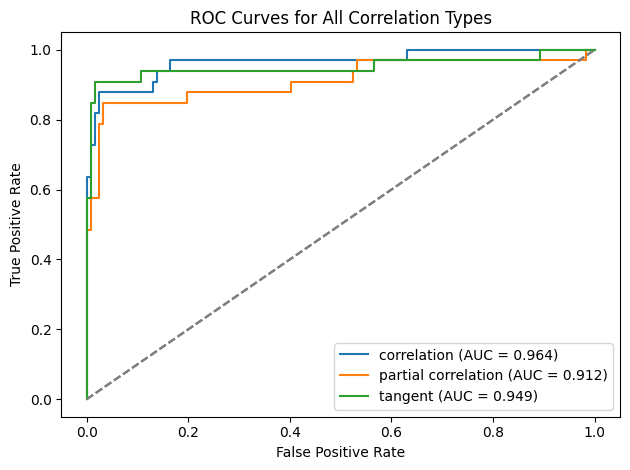

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n📈 ROC Evaluation for: {kind.upper()}")

    # Features and labels for this correlation type
    X_orig = upper_triangle_features[kind]
    y = labels

    # Refit the best model on the full data
    search.fit(X_orig, y)
    best_mlp = search.best_estimator_

    # Predict probabilities using cross-validated folds (no leakage)
    cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_proba = cross_val_predict(
        best_mlp, 
        X_orig, 
        y, 
        cv=cv5, 
        method="predict_proba", 
        n_jobs=-1
    )[:, 1]  # probability for class=1 (Adult)

    # Compute ROC curve and AUC
    fpr, tpr, thr = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{kind} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color='gray')

    # Calculate Youden’s J statistic
    j = tpr - fpr
    best_idx = j.argmax()
    best_threshold = thr[best_idx]
    print(f"✅ {kind.upper()} → Best threshold (Youden's J): {best_threshold:.4f}")

# Finalize plot after looping through all types
plt.title("ROC Curves for All Correlation Types")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


## Classification Report at Optimized Probability Threshold



📊 Classification Report & Confusion Matrix for: CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Classification Report:
              precision    recall  f1-score   support

       Child       0.97      0.98      0.97       122
       Adult       0.91      0.88      0.89        33

    accuracy                           0.95       155
   macro avg       0.94      0.93      0.93       155
weighted avg       0.95      0.95      0.95       155



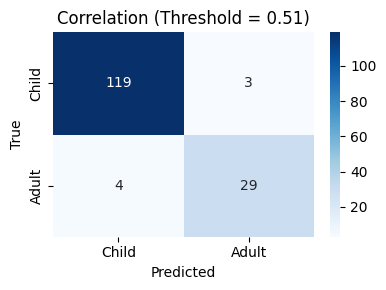


📊 Classification Report & Confusion Matrix for: PARTIAL CORRELATION
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Classification Report:
              precision    recall  f1-score   support

       Child       0.96      0.97      0.96       122
       Adult       0.88      0.85      0.86        33

    accuracy                           0.94       155
   macro avg       0.92      0.91      0.91       155
weighted avg       0.94      0.94      0.94       155



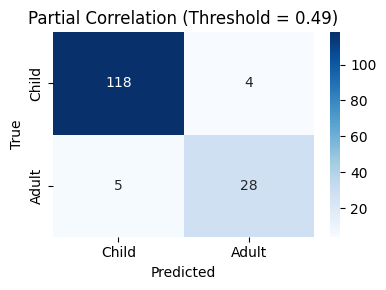


📊 Classification Report & Confusion Matrix for: TANGENT
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Classification Report:
              precision    recall  f1-score   support

       Child       0.98      0.98      0.98       122
       Adult       0.94      0.91      0.92        33

    accuracy                           0.97       155
   macro avg       0.96      0.95      0.95       155
weighted avg       0.97      0.97      0.97       155



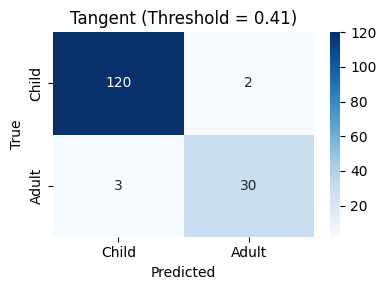

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

correlation_types = ["correlation", "partial correlation", "tangent"]

for kind in correlation_types:
    print(f"\n📊 Classification Report & Confusion Matrix for: {kind.upper()}")

    # 1️⃣ Use features for the current correlation type
    X_orig = upper_triangle_features[kind]
    y = labels

    # 2️⃣ Refit best MLP from your existing search object
    search.fit(X_orig, y)
    best_mlp = search.best_estimator_

    # 3️⃣ Get cross-validated probabilities
    from sklearn.model_selection import StratifiedKFold, cross_val_predict
    from sklearn.metrics import roc_curve, auc

    cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_proba = cross_val_predict(
        best_mlp, 
        X_orig, 
        y, 
        cv=cv5, 
        method="predict_proba", 
        n_jobs=-1
    )[:, 1]  # probability of class=1 (Adult)

    # 4️⃣ Compute ROC and optimal threshold via Youden's J
    fpr, tpr, thr = roc_curve(y, y_proba)
    j = tpr - fpr
    best_idx = j.argmax()
    best_threshold = thr[best_idx]

    # 5️⃣ Predict using best threshold
    y_pred = (y_proba >= best_threshold).astype(int)

    # 6️⃣ Classification Report
    print("Classification Report:")
    print(classification_report(y, y_pred, target_names=["Child", "Adult"]))

    # 7️⃣ Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=["Child", "Adult"],
        yticklabels=["Child", "Adult"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{kind.title()} (Threshold = {best_threshold:.2f})")
    plt.tight_layout()
    plt.show()


### 🧠 MLP – 5-Fold Cross-Validation Summary (with Grid Search, Randomized Search & SMOTE)

| Method                          | Correlation Type     | CV Accuracy (Mean ± Std) | Best AUC | Notes                                                      |
|---------------------------------|----------------------|---------------------------|----------|------------------------------------------------------------|
| GridSearchCV                    | Correlation          | 0.9097 ± 0.0474           | —        | Strong baseline performance                                |
| GridSearchCV                    | Partial Correlation  | 0.9290 ± 0.0241           | —        | Best accuracy for PC using Grid Search                     |
| GridSearchCV                    | Tangent              | 0.9548 ± 0.0258           | —        | Best overall via Grid Search                               |
| RandomizedSearchCV              | Correlation          | 0.9097 ± 0.0516           | —        | Similar to Grid, slightly more variance                    |
| RandomizedSearchCV              | Partial Correlation  | 0.8968 ± 0.0658           | —        | Lower performance than Grid                                |
| RandomizedSearchCV              | Tangent              | 0.9419 ± 0.0376           | —        | High accuracy with moderate variance                       |
| SMOTE + RandomizedSearchCV      | Correlation          | 0.9161 ± 0.0258           | 0.964    | Boosted recall and AUC; best balance overall               |
| SMOTE + RandomizedSearchCV      | Partial Correlation  | 0.8968 ± 0.0474           | 0.912    | Stable but recall for Adult slightly lower than others     |
| SMOTE + RandomizedSearchCV      | Tangent              | 0.9484 ± 0.0158           | 0.949    | Best AUC overall; strong precision/recall balance          |

📈 ROC Thresholds (Youden's J):
- Correlation: 0.5064  
- Partial Correlation: 0.4914  
- Tangent: 0.4052

✅ Tangent + SMOTE + RandomizedSearchCV achieved the best AUC (0.949) and strong metrics across classes.  
🔁 Correlation was most stable across all optimization methods.  
⚠️ Adult class recall remained lowest in Partial Correlation despite tuning.
